# Play with HRET (high res empirical tide) model

Data is available on Ed Zaron's website [here](http://web.cecs.pdx.edu/~zaron/pub/Downloads.html)

In [9]:
import xarray as xr
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

In [10]:
%matplotlib notebook

In [18]:
ds = xr.open_dataset(r'C:\Users\mrayson\cloudstor\Data\HRET\HRET_v8.1_compressed.nc')
ds = ds.sel(longitude=slice(105,130),latitude=slice(-20,-5))
ds

<xarray.Dataset>
Dimensions:    (latitude: 301, longitude: 501)
Coordinates:
  * longitude  (longitude) float64 105.0 105.0 105.1 105.1 ... 129.9 129.9 130.0
  * latitude   (latitude) float64 -20.0 -19.95 -19.9 -19.85 ... -5.1 -5.05 -5.0
Data variables:
    M2re       (latitude, longitude) float32 ...
    M2im       (latitude, longitude) float32 ...
    K1re       (latitude, longitude) float32 ...
    K1im       (latitude, longitude) float32 ...
    S2re       (latitude, longitude) float32 ...
    S2im       (latitude, longitude) float32 ...
    O1re       (latitude, longitude) float32 ...
    O1im       (latitude, longitude) float32 ...
    MA2re      (latitude, longitude) float32 ...
    MA2im      (latitude, longitude) float32 ...
    MB2re      (latitude, longitude) float32 ...
    MB2im      (latitude, longitude) float32 ...
Attributes:
    Conventions:              CF-1.7
    history:                  merged txa/j1a/j2a/j3a, txb/j1b/j2b, g1a, and e...
    resolution:             

In [20]:
amp = np.abs(ds.M2re+1j*ds.M2im)

<IPython.core.display.Javascript object>


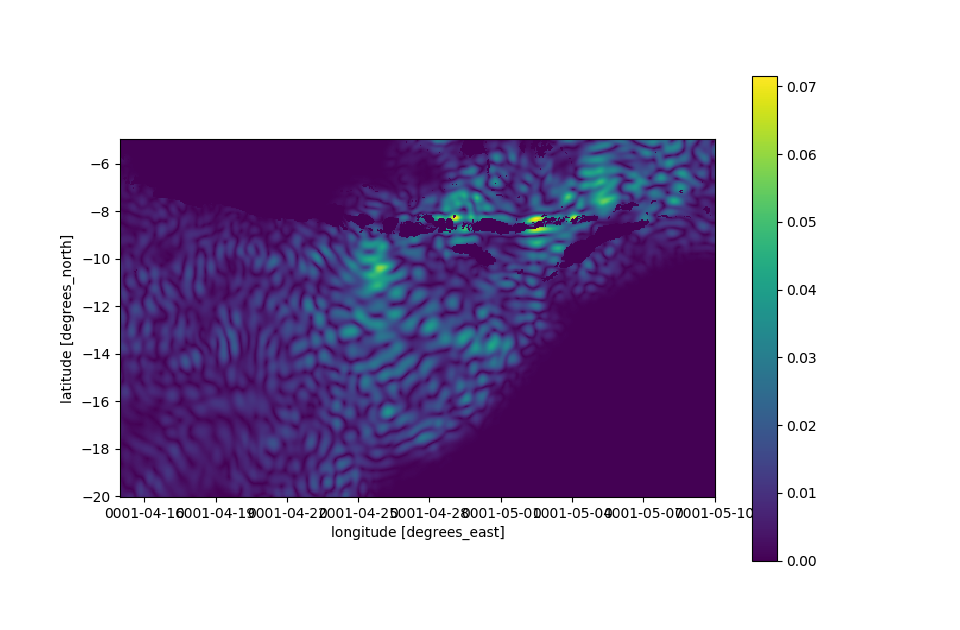

In [21]:
plt.figure()
amp.plot()
plt.gca().set_aspect('equal')

In [75]:
# Make a point prediction

lonpt = 122.8
latpt = -12.8

#lonpt = 123.346383
#latpt = -13.75895

freqs = [28.9841042, 30.0000000,15.0410686,13.9430356,28.9841042 + 360/(365.25*24), 28.9841042 - 360/(365.25*24)]
omega = [2*np.pi/(360/ff*3600) for ff in freqs]
omega

[0.00014051890250864362,
 0.0001454441043328608,
 7.292115835787053e-05,
 6.759774415077306e-05,
 0.00014071800463640936,
 0.00014031980038087792]

In [82]:
time = pd.date_range('2016-1-1','2020-1-1',freq='H')
t0 = pd.DatetimeIndex([pd.datetime(1992,1,1)])
dt = time-t0[0]
t = dt.total_seconds().values
t

array([7.573824e+08, 7.573860e+08, 7.573896e+08, ..., 8.836056e+08,
       8.836092e+08, 8.836128e+08])

In [83]:
ptds = ds.sel(longitude=lonpt,latitude=latpt, method='nearest')
ptds

<xarray.Dataset>
Dimensions:    ()
Coordinates:
    longitude  float64 122.8
    latitude   float64 -12.8
Data variables:
    M2re       float32 ...
    M2im       float32 -0.0128
    K1re       float32 ...
    K1im       float32 ...
    S2re       float32 ...
    S2im       float32 ...
    O1re       float32 ...
    O1im       float32 ...
    MA2re      float32 ...
    MA2im      float32 ...
    MB2re      float32 ...
    MB2im      float32 ...
Attributes:
    Conventions:              CF-1.7
    history:                  merged txa/j1a/j2a/j3a, txb/j1b/j2b, g1a, and e...
    resolution:               The spatial basis function coefficients are def...
    creator:                  Ed Zaron, ezaron@pdx.edu
    post-processing scripts:  baburu:NASA-Tides/Julia/; this file was written...
    scripts:                  namako:NASA-Tides/Julia/ and coeus:NASA-Tides/J...
    notes:                    This model is an update to the Carrere_HRET_tes...
    results:                  baburu:NASA

In [84]:
datavars = list(ds.data_vars.keys())
datavars

['M2re',
 'M2im',
 'K1re',
 'K1im',
 'S2re',
 'S2im',
 'O1re',
 'O1im',
 'MA2re',
 'MA2im',
 'MB2re',
 'MB2im']

In [85]:
beta = [float(ptds[vv].values) for vv in datavars]
beta

[-0.00989999994635582,
 -0.012799999676644802,
 0.00019999999494757503,
 0.00019999999494757503,
 0.0038999998942017555,
 -0.003800000064074993,
 0.0005000000237487257,
 0.0005000000237487257,
 -0.0006000000284984708,
 0.002199999988079071,
 -0.00019999999494757503,
 -0.00019999999494757503]

In [86]:
eta = 0
for ii in range(6):
    eta += beta[2*ii]*np.cos(omega[ii]*t) + beta[2*ii+1]*np.sin(omega[ii]*t)

<IPython.core.display.Javascript object>


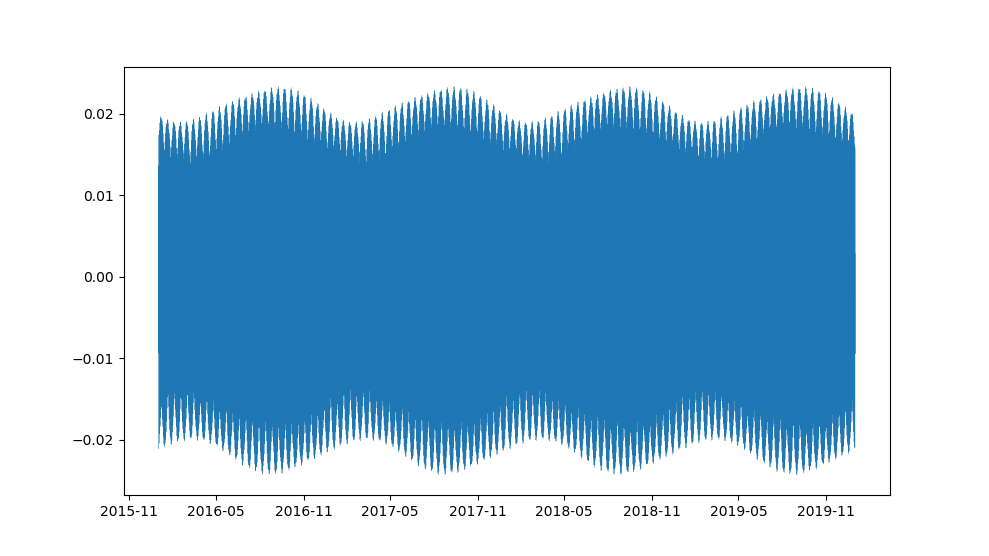

In [87]:
plt.figure()
plt.plot(time,eta,lw=0.2)